In [1]:
!nvidia-smi

Fri Jan 23 10:11:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.5/532.5 kB 11.0 MB/s eta 0:00:00


In [3]:
import transformers
import trl # trl = Transformers Reinforcement Learning -> https://github.com/huggingface/trl
import datasets
import accelerate

import gradio as gr

In [4]:
# Check the amount of GPU memory available (we need at least ~16GB)
import torch

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(device)

    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    reserved_memory = torch.cuda.memory_reserved(device)
    free_memory = total_memory - reserved_memory

    print(f"GPU: {gpu_name}")
    print(f"Total Memory:     {total_memory / 1e6:.2f} MB | {total_memory / 1e9:.2f} GB")
    print(f"Allocated Memory: {allocated_memory / 1e6:.2f} MB | {allocated_memory / 1e9:.2f} GB")
    print(f"Reserved Memory:  {reserved_memory / 1e6:.2f} MB | {reserved_memory / 1e9:.2f} GB")
    print(f"Free Memory:      {free_memory / 1e6:.2f} MB | {free_memory / 1e9:.2f} GB")
else:
    print("No CUDA GPU available")

GPU: Tesla T4
Total Memory:     15828.32 MB | 15.83 GB
Allocated Memory: 0.00 MB | 0.00 GB
Reserved Memory:  0.00 MB | 0.00 GB
Free Memory:      15828.32 MB | 15.83 GB


In [5]:
from huggingface_hub import login
login(new_session=False)

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
MODEL_NAME = "google/gemma-3-270m-it"

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "google/gemma-3-270m-it" # note: "it" stands for "instruction tuned" which means the model has been tuned for following instructions

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype="auto",
    device_map="auto", # put the model on the GPU
    attn_implementation="eager" # could use flash_attention_2 but ran into issues... so stick with Eager for now
)

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"[INFO] Model on device: {model.device}")
print(f"[INFO] Model using dtype: {model.dtype}")

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

[INFO] Model on device: cuda:0
[INFO] Model using dtype: torch.bfloat16


Our model requires numbers (tokens) as input.

We can turn strings into tokens via a tokenizer!

In [10]:
tokenizer("Hello my name is Daniel")

{'input_ids': [2, 9259, 1041, 1463, 563, 13108], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [12]:
import torch

outputs = model(torch.tensor(tokenizer("Hello my name is Daniel")["input_ids"]).unsqueeze(0).to(model.device))
outputs.keys()

odict_keys(['logits', 'past_key_values'])

Load the dataset

In [13]:
from datasets import load_dataset

dataset = load_dataset("mrdbourke/FoodExtract-1k")

print(f"[INFO] Number of samples in the dataset: {len(dataset['train'])}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/616k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1420 [00:00<?, ? examples/s]

[INFO] Number of samples in the dataset: 1420


In [14]:
import json
import random

def get_random_idx(dataset):
    """Returns a random integer index based on the number of samples in the dataset."""
    random_idx = random.randint(0, len(dataset)-1)
    return random_idx


random_idx = get_random_idx(dataset["train"])
random_sample = dataset["train"][random_idx]

example_input = random_sample["sequence"]
example_output = random_sample["gpt-oss-120b-label"]
example_output_condensed = random_sample["gpt-oss-120b-label-condensed"]

print(f"[INFO] Input:\n{example_input}")
print()
print(f"[INFO] Example structured output (what we want our model to learn to predict):")
print(eval(example_output))
print()
print(f"[INFO] Example output condensed (we'll train our model to predict the condensed output since it uses less tokens than JSON):")
print(example_output_condensed)

[INFO] Input:
In this horizontally-aligned rectangular image, an indoor badminton game is in progress. The gym's walls are decorated with blue on the bottom and yellow on top. The upper section features several windows; some are closed with horizontal blinds while others are without. The playing surface is a green court distinguished by blue and red lines, creating a colorful contrast. The viewer’s perspective captures the net stretching from the right edge to almost the left edge, where the pole is cut off by the image's frame. 

In the foreground, two female players in white shirts and black shorts dominate the scene. One player, with a long brown ponytail, has her arm raised, poised to hit the birdie. Next to the net, a referee clad in all black sits in a tall chair against the blue wall, overseeing the match. On the opposite side of the net, opposing players also wear black attire and appear ready to receive the shuttlecock. Spectators are casually scattered in the background, obse

In [15]:
# Our fine-tuned model will assign tags to text so we can easily filter them by type in the future
tags_dict = {'np': 'nutrition_panel',
             'il': 'ingredient list',
             'me': 'menu',
             're': 'recipe',
             'fi': 'food_items',
             'di': 'drink_items',
             'fa': 'food_advertistment',
             'fp': 'food_packaging'}

In [16]:
tags_dict.items()

dict_items([('np', 'nutrition_panel'), ('il', 'ingredient list'), ('me', 'menu'), ('re', 'recipe'), ('fi', 'food_items'), ('di', 'drink_items'), ('fa', 'food_advertistment'), ('fp', 'food_packaging')])

### Format the dataset into LLM-style inputs/outputs

Right now we have examples of string-based inputs and structured outputs.

However, our LLMs generally want things in the format of:

```
{"user": "Hello my name is Daniel",
"system": "Hi Daniel, I'm an LLM"}
```

In other words, they want structure around the intputs and outputs rather than just raw information.

> **Resource:** See the dataset formats and types in the TRL docs: https://huggingface.co/docs/trl/en/dataset_formats

In [17]:
random_sample

{'sequence': 'In this horizontally-aligned rectangular image, an indoor badminton game is in progress. The gym\'s walls are decorated with blue on the bottom and yellow on top. The upper section features several windows; some are closed with horizontal blinds while others are without. The playing surface is a green court distinguished by blue and red lines, creating a colorful contrast. The viewer’s perspective captures the net stretching from the right edge to almost the left edge, where the pole is cut off by the image\'s frame. \n\nIn the foreground, two female players in white shirts and black shorts dominate the scene. One player, with a long brown ponytail, has her arm raised, poised to hit the birdie. Next to the net, a referee clad in all black sits in a tall chair against the blue wall, overseeing the match. On the opposite side of the net, opposing players also wear black attire and appear ready to receive the shuttlecock. Spectators are casually scattered in the background, 

Transform the dataset into LLM input and output sequences format

In [19]:
def sample_to_conversation(sample):
    """Helper function to convert an input sample to conversation style."""
    return {
        "messages": [
            {"role": "user", "content": sample["sequence"]}, # Load the sequence from the dataset
            {"role": "system", "content": sample["gpt-oss-120b-label-condensed"]} # Load the gpt-oss-120b generated label
        ]
    }

sample_to_conversation(random_sample)

{'messages': [{'role': 'user',
   'content': 'In this horizontally-aligned rectangular image, an indoor badminton game is in progress. The gym\'s walls are decorated with blue on the bottom and yellow on top. The upper section features several windows; some are closed with horizontal blinds while others are without. The playing surface is a green court distinguished by blue and red lines, creating a colorful contrast. The viewer’s perspective captures the net stretching from the right edge to almost the left edge, where the pole is cut off by the image\'s frame. \n\nIn the foreground, two female players in white shirts and black shorts dominate the scene. One player, with a long brown ponytail, has her arm raised, poised to hit the birdie. Next to the net, a referee clad in all black sits in a tall chair against the blue wall, overseeing the match. On the opposite side of the net, opposing players also wear black attire and appear ready to receive the shuttlecock. Spectators are casual

In [20]:
# Map our sample_to_conversation function to dataset
dataset = dataset.map(sample_to_conversation,
                      batched=False)

dataset["train"][0]

Map:   0%|          | 0/1420 [00:00<?, ? examples/s]

{'sequence': 'A mouth-watering photograph captures a delectable dish centered on a rectangular white porcelain plate, resting on a rustic wooden tabletop indoors. In the background, a wooden cutting board with a long handle subtly enhances the setting. The plate is adorned with several generously-sized, cheese-stuffed peppers that have been roasted to perfection, their blistered skins marked by charred black spots. Split down the middle, the peppers reveal a creamy white cheese filling, enriched with a blend of aromatic herbs. Once stuffed, the peppers have been closed and roasted, achieving a luscious, smoky flavor.\n\nThe dish is elegantly garnished with vibrant cherry tomato halves, freshly chopped green herbs, and delicate sprinkles of small diced red onions. A light, possibly citrus-infused dressing, hinted by a sheen of oil or lime juice, gently coats the ensemble, adding an extra layer of freshness. The meticulous presentation and vivid colors make this image not only a feast fo

In [21]:
#Create a train/test split
dataset = dataset["train"].train_test_split(test_size=0.2,shuffle=False,seed=42)
dataset


DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 284
    })
})

Try the model with pipeline

In [23]:
model

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 640, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=640, out_features=1024, bias=False)
          (k_proj): Linear(in_features=640, out_features=256, bias=False)
          (v_proj): Linear(in_features=640, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=640, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=640, out_features=2048, bias=False)
          (up_proj): Linear(in_features=640, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=640, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((640,), eps=1e-06)

In [24]:
easy_sample = {"role": "user",
               "content": "Hi my name is Daniel"}

def create_easy_sample(input):
    template = {"role": "user", "content": input}
    return template

In [25]:
from transformers import pipeline

# Load model and use it as a pipeline
pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer)

input_text = "Hi my name is Daniel. Please reply to me with a machine learning poem."
easy_sample = create_easy_sample(input=input_text)
input_prompt = pipe.tokenizer.apply_chat_template([easy_sample], # pipeline tokenizer wants a list of inputs
                                                  tokenize=False,
                                                  add_generation_prompt=True)

print(f"[INFO] This is the input prompt: {input_prompt}")

default_outputs = pipe(input_prompt,
                       max_new_tokens=512,
                       disable_compile=True)

print(f"[INFO] Input:\n{input_text}")
print()
print(f"[INFO] Output from {MODEL_NAME}:")
print()
print(default_outputs[0]["generated_text"][len(input_prompt):])

Device set to use cuda:0


[INFO] This is the input prompt: <bos><start_of_turn>user
Hi my name is Daniel. Please reply to me with a machine learning poem.<end_of_turn>
<start_of_turn>model

[INFO] Input:
Hi my name is Daniel. Please reply to me with a machine learning poem.

[INFO] Output from google/gemma-3-270m-it:

Okay, here's a machine learning poem for you:

A silent engine, a digital heart,
Learning patterns, a world to fulfill.
From data streams, a complex design,
Unlocking secrets, a future shine.

The algorithms weave, a guiding hand,
To predict and understand, a helping strand.
With each passing day, the data grows deeper,
Exploring the hidden, the untold store.

A symphony of logic, a vibrant hue,
Where patterns bloom, and insights accrue.
No words required, just data's soft grace,
A learning journey, time and space embrace.

So let the algorithms learn and grow,
A future bright, a vibrant, hopeful glow.



### Try the model on one of our sequences

In [26]:
# Get a random sample
random_idx = get_random_idx(dataset["train"])
random_train_sample = dataset["train"][random_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_train_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
the boy gives a flower to the girl<end_of_turn>
<start_of_turn>model


[INFO] Output:
The boy gives a flower to the girl.



### Let's try to prompt the model

We want a model to extract food and drink items from text.

By default the model will just reply to any text input with a generic response.

However, we can try and get our ideal outputs via prompting.

In [27]:
prompt_instruction = """Given the following target input text from an image caption, please extract the food and drink items to a list.
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: <targ_input_text>"""

def update_input_message_content(input):
    original_content = input["messages"][:1][0]["content"]
    new_content = prompt_instruction.replace("<targ_input_text>", original_content)

    new_input = [{"content": new_content,
                  "role": "user"}]

    return new_input

print(f'[INFO] Original content:\n{random_train_sample["messages"][:1][0]["content"]}')
print()
print(f'[INFO] New content with instructions in prompt:')
print(update_input_message_content(input=random_train_sample)[0]["content"])

[INFO] Original content:
the boy gives a flower to the girl

[INFO] New content with instructions in prompt:
Given the following target input text from an image caption, please extract the food and drink items to a list.
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: the boy gives a flower to the girl


In [28]:
# Apply the chat template
updated_input_prompt = update_input_message_content(input=random_train_sample)

input_prompt = pipe.tokenizer.apply_chat_template(conversation=updated_input_prompt,
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt,
                       max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
Given the following target input text from an image caption, please extract the food and drink items to a list.
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: the boy gives a flower to the girl<end_of_turn>
<start_of_turn>model


[INFO] Output:
food_items: []
drink_items: []



In [29]:
# This is our input
print(random_train_sample["messages"][0]["content"])
print()

# This is our ideal output:
print(random_train_sample["messages"][1]["content"])

the boy gives a flower to the girl

food_or_drink: 0
tags: 
foods: 
drinks:


In [30]:
# This is our input
print(random_train_sample["messages"][0]["content"])
print()

# This is our ideal output:
print(random_train_sample["messages"][1]["content"])

the boy gives a flower to the girl

food_or_drink: 0
tags: 
foods: 
drinks:


Okay looks like our small LLM doesn't do what we want it to do... it starts to reply with Python text or unreliably extracts foods and drinks from text in a non-uniform format.

No matter, we can fine-tune it so it does our specific task!

## Fine-tuning our model

Steps:

1. Setup SFTConfig (Supervised Fine-tuning Config) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTConfig
2. Use SFTTrainer to train our model on our supervised samples (from our dataset above) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTTrainer

In [31]:
# Setting up our SFTConfig
from trl import SFTConfig

torch_dtype = model.dtype

CHECKPOINT_DIR_NAME = "./checkpoint_models"
BASE_LEARNING_RATE = 5e-5

print(f"[INFO] Using dtype: {torch_dtype}")
print(f"[INFO] Using learning rate: {BASE_LEARNING_RATE}")

[INFO] Using dtype: torch.bfloat16
[INFO] Using learning rate: 5e-05


In [39]:
sft_config = SFTConfig(
    output_dir=CHECKPOINT_DIR_NAME,
    max_length=512,
    packing=False,
    num_train_epochs=3,
    per_device_train_batch_size=8, # Reduced batch size
    per_device_eval_batch_size=8, # Reduced batch size
    gradient_checkpointing=True, # Enabled gradient checkpointing
    optim="adamw_torch_fused",
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=BASE_LEARNING_RATE,
    fp16=False, # explicitly set to False as we are using bf16
    bf16=True, # Ensure bf16 is True when using bfloat16 model
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to=None
)

In [44]:
# Supervised Fine-Tuning = provide input and desired output samples
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"]
    # Removed tokenizer=tokenizer as it's causing a TypeError
)

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [35]:
!pip install weave

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 822.4/822.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 9.5 MB/s eta 0:00:00


In [36]:
import weave

weave: Logged in as Weights & Biases user: mdkaraamathullahsheriff.
weave: View Weave data at https://wandb.ai/mdkaraamathullahsheriff-crescent-university-alumni/huggingface/weave


In [45]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.743300,2.263952


Epoch,Training Loss,Validation Loss
1,1.743300,2.263952
2,1.415400,2.294692
3,1.614800,2.411692


TrainOutput(global_step=426, training_loss=1.7878991512345597, metrics={'train_runtime': 1323.5019, 'train_samples_per_second': 2.575, 'train_steps_per_second': 0.322, 'total_flos': 752734058926080.0, 'train_loss': 1.7878991512345597})

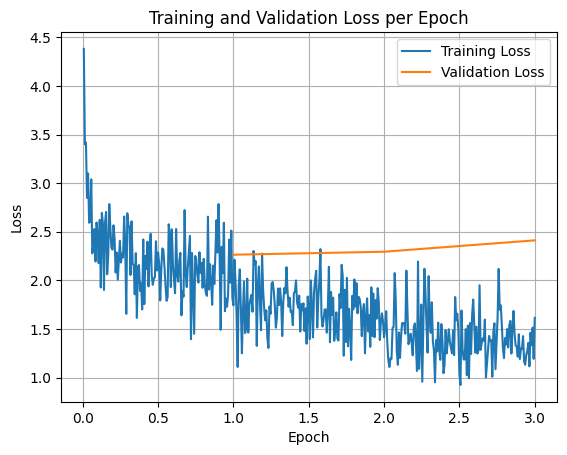

In [46]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Save the model
trainer.save_model()

In [48]:
# Remove all the checkpoint folders (since we've already saved the best model)
!rm -rf ./checkpoint_models/checkpoint-*/*
!rm -rf ./checkpoint_models/checkpoint-*

## Load the trained model back in and see how it performs

We've now fine-tuned our own Gemma 3 270M to do a specific task, let's load it back in and see how it performs.

In [49]:
CHECKPOINT_DIR_NAME

'./checkpoint_models'

In [52]:
# Load the fine-tuned model and see how it goes
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load trained model
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=CHECKPOINT_DIR_NAME,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
);

In [53]:
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

loaded_model_pipeline

Device set to use cuda:0


In [54]:
dataset["test"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 284
})

In [55]:
# Get a random sample
random_test_idx = get_random_idx(dataset["test"])
random_test_sample = dataset["test"][random_test_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_test_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = loaded_model_pipeline(text_inputs=input_prompt,
                                        max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
The image shows a package of "Helpful Harvest" dried vegetables. The ingredients include a variety of vegetables such as zucchini, carrots, mushrooms, onions, capsicum, and celery. The product is made from 100% vegetables and includes wonky and overly abundant produce where possible. The package notes that the ingredients and percentages may differ due to seasonal availability.

The allergens listed are milk, eggs, soy, sesame seeds, hazelnuts, pistachios, cashews, and almonds. The nutrition information indicates that the package contains 4 servings, with each serving size being 10g. The average quantities per serving are as follows:
- Energy: 125 kJ
- Protein: 1.9 g
- Gluten: 0 g (marked as gluten-free)
- Fat, total: 0.3 g
- Saturated fat: 0 g
- Carbohydrate: 3.4 g
- Sugars: 3.4 g
- Fibre: 3.4 g
- Sodium: 2.1 g

The average quantities per 100g are:
- Energy: 1250 kJ
- Protein: 18.7 g
- Fat, total: 2.8 g
- Saturated fat: 0 g
- Carbohydrate: 34.3 g

In [56]:
print(random_test_sample["gpt-oss-120b-label-condensed"])

food_or_drink: 1
tags: np, il, fi, fp
foods: zucchini, carrots, mushrooms, onions, capsicum, celery, milk, eggs, soy, sesame seeds, hazelnuts, pistachios, cashews, almonds
drinks:


## Counting the number of parameters in our model

In [57]:
def get_model_num_params(model):
    """
    Returns the number of trainable, non-trainable and total parameters of a PyTorch model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    return {"trainable_params": trainable_params,
            "non_trainable_params": non_trainable_params,
            "total_params": total_params}

# Get parameters of our fine-tuned model
model_params = get_model_num_params(loaded_model)
print(f"Trainable parameters: {model_params['trainable_params']:,}")
print(f"Non-trainable parameters: {model_params['non_trainable_params']:,}")
print(f"Total parameters: {model_params['total_params']:,}")

Trainable parameters: 268,098,176
Non-trainable parameters: 0
Total parameters: 268,098,176


In [59]:
# Our model is 270M parameters, GPT-OSS-120B is 120B parameters
120_000_000_000 / 270_000_000

444.44444444444446

## Uploading our fine-tuned model to the Hugging Face Hub

In [60]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

MODEL_PATH = "./checkpoint_models/"

# Load the model into a pipeline
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=MODEL_PATH,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH
)

# Create a pipeline from the loaded model
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

# Test the loaded model on raw text (this won't work as well as formatted text)
test_input_message = "Hello my name is Daniel!"
loaded_model_pipeline(test_input_message)

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.
The tokenizer you are loading from './checkpoint_models/' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0


[{'generated_text': 'Hello my name is Daniel!'}]

Let's create a helper function to format our input text into message format.

In [61]:
def format_message(input):
    return [{"role": "user", "content": input}]

input_formatted = format_message(input=test_input_message)
input_formatted

[{'role': 'user', 'content': 'Hello my name is Daniel!'}]

Now we can turn it into a prompt with our `tokenizer` and the `apply_chat_template` method.

In [62]:
input_prompt = loaded_model_pipeline.tokenizer.apply_chat_template(conversation=input_formatted,
                                                                   tokenize=False,
                                                                   add_generation_prompt=True)

input_prompt

'<bos><start_of_turn>user\nHello my name is Daniel!<end_of_turn>\n<start_of_turn>model\n'

In [63]:
loaded_model_outputs = loaded_model_pipeline(text_inputs=input_prompt,
                                             max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{loaded_model_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
Hello my name is Daniel!<end_of_turn>
<start_of_turn>model


[INFO] Output:
food_or_drink: 0
tags: 
foods: 
drinks:


Okay let's make another helper function to predict on any given sample input.

We'll also return the inference time of our model so we can see how long things take.

In [64]:
import time

def pred_on_text(input_text):
    start_time = time.time()

    raw_output = loaded_model_pipeline(text_inputs=[{"role": "user",
                                                    "content": input_text}],
                                       max_new_tokens=256,
                                       disable_compile=True)
    end_time = time.time()
    total_time = round(end_time - start_time, 4)

    generated_text = raw_output[0]["generated_text"][1]["content"]

    return generated_text, raw_output, total_time

pred_on_text(input_text="British Breakfast with baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea and toast and fried tomatoes")

('food_or_drink: 1\ntags: fi, di\nfoods: baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, toast, fried tomatoes\ndrinks: tea',
 [{'generated_text': [{'role': 'user',
     'content': 'British Breakfast with baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea and toast and fried tomatoes'},
    {'role': 'assistant',
     'content': 'food_or_drink: 1\ntags: fi, di\nfoods: baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, toast, fried tomatoes\ndrinks: tea'}]}],
 1.9145)

Nice! Looks like our model is working well enough (of course we could always improve it over time with more testing and different samples).

Let's upload it to the Hugging Face Hub.

We can do so using the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/en/index).

In [65]:
from huggingface_hub import HfApi, create_repo

api = HfApi()

# Give our model a name (this is in the format [Hugging Face Username]/[Target Model Name]
repo_id = "Sheriffc555/FoodExtract-gemma-3-270m-fine-tune-v1"

# Create the repo
create_repo(repo_id,
            repo_type="model",
            exist_ok=True)

# Upload the entire model folder containing our model files
api.upload_folder(
    folder_path="./checkpoint_models/",
    repo_id=repo_id,
    repo_type="model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...nt_models/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...int_models/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ..._models/model.safetensors:   0%|          |  601kB /  536MB            

  ...63750.5abdfa1e2507.3156.0:   6%|6         | 1.17kB / 18.6kB            

  ...64289.5abdfa1e2507.3156.1:   6%|6         | 10.7kB /  170kB            

  ..._models/training_args.bin:   6%|6         |   396B / 6.29kB            

CommitInfo(commit_url='https://huggingface.co/Sheriffc555/FoodExtract-gemma-3-270m-fine-tune-v1/commit/60abd7f075dc8fad433ee1a4492d41d5ff8bbb6e', commit_message='Upload folder using huggingface_hub', commit_description='', oid='60abd7f075dc8fad433ee1a4492d41d5ff8bbb6e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Sheriffc555/FoodExtract-gemma-3-270m-fine-tune-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='Sheriffc555/FoodExtract-gemma-3-270m-fine-tune-v1'), pr_revision=None, pr_num=None)

Woohoo! Our model is officially on the Hugging Face Hub.

Now not only can we redownload it and use it again, others can download it and use it for themselves (of course you can make the model private if you like too).

## Turn our model into a demo

Right now our model seems to be working quite well for our specific use case.

However, it takes some coding to be able to use it.

What if we wanted to allow someone who wasn't familiar with programming to try it out?

To do so, we can turn our model into a [Gradio](https://www.gradio.app) demo and upload it to [Hugging Face Spaces](https://huggingface.co/spaces) (a place to share all kinds of small applications).

Gradio allows us to turn our model into an easy to use and sharable demo anyone can try.

Gradio demos work on the premise of: input (text) -> function (our model) -> output (text)

We've already go a function ready with `pred_on_text` so we can wrap this with some Gradio code.

To create a sharable demo, we'll need the following files:

* `app.py` - Entry point for our app, all of our application code will go in here.
* `README.md` - Tells people what our app does.
    * **Note:** Hugging Face Spaces use a special "front matter" (text at the start of a `README.md` file) to add various attributes to a Hugging Face Space, we'll see this below.
* `requirements.txt` - Tells Hugging Face Spaces what our app requires.
    * `torch`, `transformers`, `gradio`, `accelerate`

Let's make a folder to store our demo application.


<------------------------------------------------------------------------------------------------->